| **Name**         | Tufan Kundu               |
|------------------|---------------------------|
| **Reg No.**      | 24MDT0184                 |
| **Course Name**  | Financial Analytics Lab   |
| **Course Code**  | PMDS610P                  |
| **Assessment**   | Lab Digital Assessment 5  |


# Problem Statement
 You are given historical daily closing prices of the stock from NIFTY 50  index from the National Stock Exchange of India (NSE). Your task is to analyze the volatility of stock prices using a Generalized Autoregressive Conditional Heteroskedasticity (GARCH) Model. Investigate the presence of heteroskedasticity and fit an appropriate GARCH model to capture volatility clustering

### Importing the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings 
warnings.filterwarnings('ignore')


In [3]:
# -----------------------------------------------
# 2.1 Data Preprocessing
# -----------------------------------------------
# Load NIFTY 50 data from Yahoo Finance (Jan 1, 2019 to Jan 1, 2024)
import yfinance as yf

## Choosing stock of HDFC bank for analysis
stock = yf.Ticker('HDFCBANK.BO')
nifty = stock.history(period="5y")
    
# Retain only the 'Close' column
nifty = nifty[['Close']]

# Convert index to datetime and set as index
nifty.index = pd.to_datetime(nifty.index)

# Compute log returns for volatility analysis
nifty['Log_Returns'] = np.log(nifty['Close'] / nifty['Close'].shift(1)).dropna()
# Debug: Check Log_Returns data
print("Log_Returns head:", nifty['Log_Returns'].head())
print("Log_Returns dtype:", nifty['Log_Returns'].dtype)

Log_Returns head: Date
2020-04-07 00:00:00+05:30         NaN
2020-04-08 00:00:00+05:30   -0.008290
2020-04-09 00:00:00+05:30    0.038996
2020-04-13 00:00:00+05:30   -0.031710
2020-04-15 00:00:00+05:30   -0.036390
Name: Log_Returns, dtype: float64
Log_Returns dtype: float64


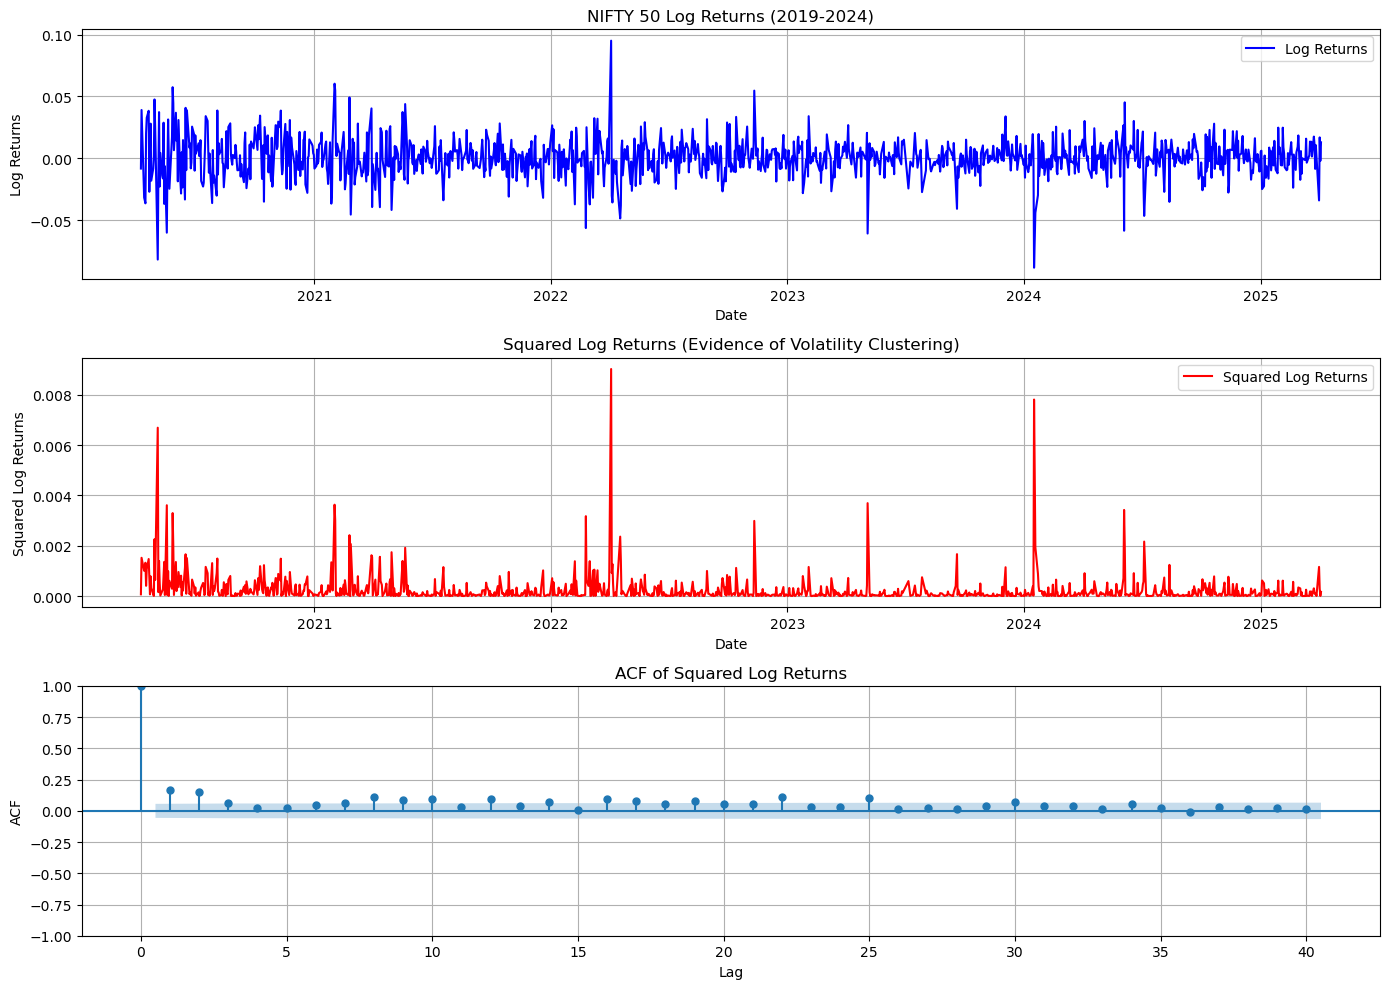

In [4]:
# Exploratory Data Analysis (EDA) for volatility clustering
plt.figure(figsize=(14, 10))

# Plot log returns
plt.subplot(3, 1, 1)
plt.plot(nifty['Log_Returns'], label='Log Returns', color='blue')
plt.title('NIFTY 50 Log Returns (2019-2024)')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True)
# Plot squared log returns to detect volatility clustering
plt.subplot(3, 1, 2)
plt.plot(nifty['Log_Returns']**2, label='Squared Log Returns', color='red')
plt.title('Squared Log Returns (Evidence of Volatility Clustering)')
plt.xlabel('Date')
plt.ylabel('Squared Log Returns')
plt.legend()
plt.grid(True)
# ACF plot of squared returns to confirm volatility clustering
squared_returns = (nifty['Log_Returns'] ** 2).dropna()  
plt.subplot(3, 1, 3)
plot_acf(squared_returns, lags=40, ax=plt.gca())
plt.title('ACF of Squared Log Returns')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:

# Check stationarity of log returns
adf_result = adfuller(nifty['Log_Returns'].dropna())
print("\nADF Test on Log Returns:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

if adf_result[1] < 0.05:
    print("Log returns are stationary.")
else:
    print("Log returns are non-stationary.")


# -----------------------------------------------
# 2.2 Modeling Volatility with GARCH
# -----------------------------------------------
# Fit GARCH(1,1) model using Maximum Likelihood Estimation (MLE)
garch_model = arch_model(nifty['Log_Returns'].dropna(), vol='Garch', p=1, q=1, dist='normal')
garch_results = garch_model.fit(update_freq=10, disp='off')

# Print GARCH model summary
print("\nGARCH(1,1) Model Summary:")
print(garch_results.summary())
# -----------------------------------------------




ADF Test on Log Returns:
ADF Statistic: -13.423245571506643
p-value: 4.149783587104904e-25
Log returns are stationary.

GARCH(1,1) Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3419.37
Distribution:                  Normal   AIC:                          -6830.74
Method:            Maximum Likelihood   BIC:                          -6810.33
                                        No. Observations:                 1215
Date:                Sat, Apr 05 2025   Df Residuals:                     1214
Time:                        16:20:33   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.

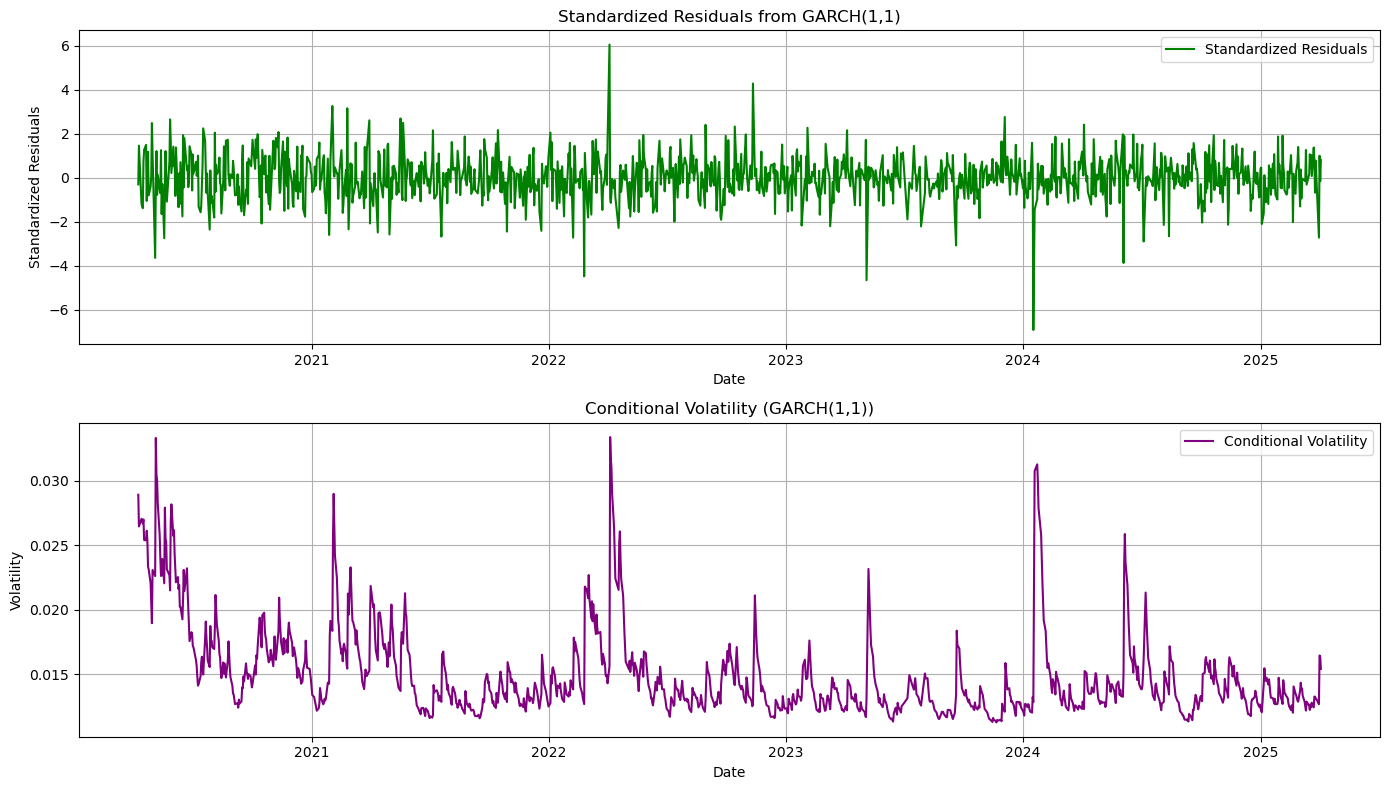


Ljung-Box Test on Squared Standardized Residuals:
     lb_stat  lb_pvalue
10  5.018576   0.889934
20  8.643630   0.986679


In [6]:
# 2.3 Model Evaluation and Forecasting
# -----------------------------------------------
# Diagnostic plots
plt.figure(figsize=(14, 8))

# Plot standardized residuals
plt.subplot(2, 1, 1)
std_residuals = garch_results.resid / garch_results.conditional_volatility
plt.plot(nifty.index[len(nifty) - len(std_residuals):], std_residuals, label='Standardized Residuals', color='green')
plt.title('Standardized Residuals from GARCH(1,1)')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.legend()
plt.grid(True)

# Plot conditional volatility
plt.subplot(2, 1, 2)
plt.plot(nifty.index[len(nifty) - len(garch_results.conditional_volatility):], 
         garch_results.conditional_volatility, label='Conditional Volatility', color='purple')
plt.title('Conditional Volatility (GARCH(1,1))')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
# Ljung-Box test on squared standardized residuals to evaluate model fit
lb_test = acorr_ljungbox(std_residuals**2, lags=[10, 20], return_df=True)
print("\nLjung-Box Test on Squared Standardized Residuals:")
print(lb_test)



30-Day Volatility Forecast (Annualized Standard Deviation):
Day 1: 0.2403
Day 2: 0.2406
Day 3: 0.2408
Day 4: 0.2410
Day 5: 0.2412
Day 6: 0.2414
Day 7: 0.2415
Day 8: 0.2416
Day 9: 0.2418
Day 10: 0.2419
Day 11: 0.2420
Day 12: 0.2421
Day 13: 0.2421
Day 14: 0.2422
Day 15: 0.2423
Day 16: 0.2423
Day 17: 0.2424
Day 18: 0.2424
Day 19: 0.2425
Day 20: 0.2425
Day 21: 0.2425
Day 22: 0.2426
Day 23: 0.2426
Day 24: 0.2426
Day 25: 0.2426
Day 26: 0.2427
Day 27: 0.2427
Day 28: 0.2427
Day 29: 0.2427
Day 30: 0.2427


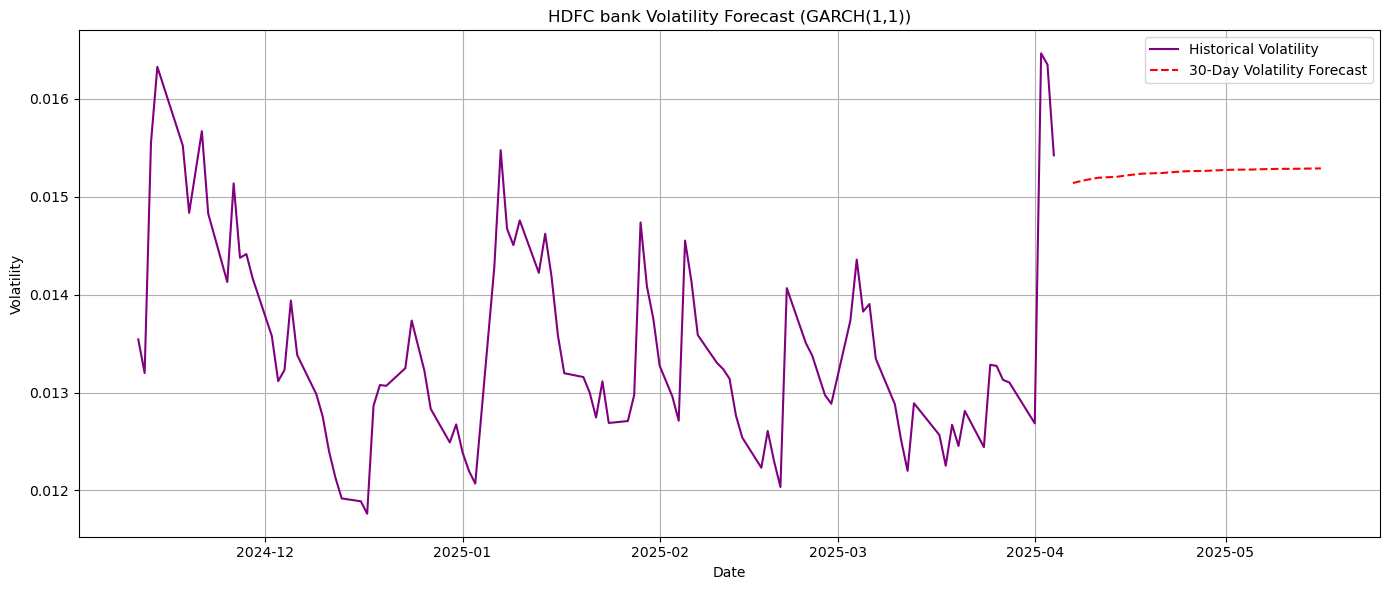

In [7]:
# Forecast volatility for the next 30 days
forecast_horizon = 30
forecast = garch_results.forecast(horizon=forecast_horizon, start=None)
forecast_volatility = np.sqrt(forecast.variance.dropna().iloc[-1].values)

# Print annualized volatility forecast
print("\n30-Day Volatility Forecast (Annualized Standard Deviation):")
for i, vol in enumerate(forecast_volatility, 1):
    annualized_vol = vol * np.sqrt(252)  # Annualize by multiplying by sqrt(252)
    print(f"Day {i}: {annualized_vol:.4f}")
    
# Plot historical and forecasted volatility (last 100 days + 30-day forecast)
plt.figure(figsize=(14, 6))
plt.plot(nifty.index[-100:], garch_results.conditional_volatility[-100:], 
         label='Historical Volatility', color='purple')
future_dates = pd.date_range(start=nifty.index[-1] + pd.Timedelta(days=1), 
                            periods=forecast_horizon, freq='B')
plt.plot(future_dates, forecast_volatility, label='30-Day Volatility Forecast', 
         color='red', linestyle='--')
plt.title('HDFC bank Volatility Forecast (GARCH(1,1))')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()